In [166]:
import uproot
import matplotlib.pyplot as plt 
import matplotlib as mpl
import mplhep as hep
import numpy as np
import fnmatch
from scipy.signal import find_peaks
import hist
import pandas as pd

In [493]:
idx_u0 = 0 
idx_v0 = 1984
idx_w0 = 3968
idx_u1 = 5632
idx_v1 = 7616
idx_w1 = 9000

def find_u0_ch(ch_num):
    if (((ch_num >= 0 ) & (ch_num < idx_v0))):
        return True
    else:
        return False

def find_v0_ch(ch_num):
    if (((ch_num >= idx_v0 ) & (ch_num < idx_w0))):
        return True
    else:
        return False
    
def find_w0_ch(ch_num):
    if (((ch_num >= idx_w0 ) & (ch_num < idx_u1))):
        return True
    else:
        return False
    
def find_u1_ch(ch_num):
    if (((ch_num >=  idx_u1 ) & (ch_num < idx_v1))):
        return True
    else:
        return False

def find_v1_ch(ch_num):
    if (((ch_num >= idx_v1 ) & (ch_num < idx_w1))):
        return True
    else:
        return False
    
def find_w1_ch(ch_num):
    if (((ch_num >= idx_w1 ))):
        return True
    else:
        return False

def u_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    tpc1_arr = input[idx_u1:idx_v1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def v_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    tpc1_arr = input[idx_v1:idx_w1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def w_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    tpc1_arr = input[idx_w1:]
    return np.concatenate([tpc0_arr,tpc1_arr])

def u0_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    return tpc0_arr

def v0_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    return tpc0_arr

def w0_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    return tpc0_arr

def u1_ch(input): 
    tpc1_arr = input[idx_u1:idx_v1]
    return tpc1_arr

def v1_ch(input): 
    tpc1_arr = input[idx_v1:idx_w1]
    return tpc1_arr

def w1_ch(input): 
    tpc1_arr = input[idx_w1:]
    return tpc1_arr

def quartile_reso(data):
    data = np.round(np.sort(data),3)
    median = np.median(data)
    median_idx = int(np.round(len(data)/2))
    quar_size =  int(np.round(len(data)*0.5*0.683))
    Q1 = data[median_idx - quar_size]
    Q3 = data[median_idx + quar_size]
    quartile_reso = np.sqrt(0.5*(median-Q1)**2 + 0.5*(median-Q3)**2)
    return quartile_reso

def find_nonzero_ch(wvfm):
    # peak threshold = 800
    mask = (wvfm > 800).sum(axis = 1)
    return np.where(mask>0)[0]

In [516]:
def pass_decon(dec_arr):
    """
    Returns a np.array of deconvolved channels with either 800 e- peak height or average charge above 400 e-
    """
    dec_sum = np.sum(dec_arr,axis=1)
    dec_ch  = np.where(dec_sum>1)[0] # array of ch numbers, nonzero channels
    # list of channels with peak height above 800
    pass_peak = dec_ch[np.where(np.max(dec_arr[dec_ch],axis=1)>800)[0]]
    pass_avg  = []
    # if a channel has nonzero but peak height below 800:
    for ch in dec_ch[np.where(np.max(dec_arr[dec_ch],axis=1)<800)[0]]:
        dec_peak, dec_prop = find_peaks(dec_arr[ch],height=5,width=0)
        # in case there are multiple peaks in the waveform, take the one with the highest peak height
        if len(dec_peak) ==0: continue
        peak_idx = np.argmax(dec_prop["peak_heights"])
        dec_charge = dec_arr[ch][dec_prop["left_bases"][peak_idx]:dec_prop["right_bases"][peak_idx]].sum()
        dec_width  = dec_prop["right_bases"][peak_idx]-dec_prop["left_bases"][peak_idx]
        # calculate the average charge in the peak
        dec_avg = dec_charge / dec_width
        if dec_avg > 400: pass_avg.append(ch)
    pass_avg = np.array(pass_avg,dtype=int)
    dec_pass = np.concatenate([pass_peak,pass_avg])
    ch_bool = np.zeros(len(dec_arr),dtype=bool)
    ch_bool[dec_pass] = True
    return ch_bool

def pass_sim(sim_arr):
    """
    Returns a np.array of simulated channels with integrated charge (for the largest hit) above 2500
    """
    sim_ch = np.where(np.sum(sim_arr,axis=1)>=2500)[0]
    for ch in sim_ch:
        sim_peak, sim_prop = find_peaks(sim_arr[ch],height=5,width=0)
        peak_idx = np.argmax(sim_prop["peak_heights"])
        sim_charge = sim_arr[ch][sim_prop["left_bases"][peak_idx]:sim_prop["right_bases"][peak_idx]].sum()
        if sim_charge < 2500: sim_ch = np.delete(sim_ch,np.where(sim_ch==ch))
    ch_bool = np.zeros(len(sim_arr),dtype=bool)
    ch_bool[sim_ch] = True
    return ch_bool

In [3]:
caf_file = "prodsingle_sbnd_SinglesGen-20230830T141006_G4-20230830T141501_WCLS-20230830T142603.flat.caf.root"
caf = uproot.open(caf_file+":recTree")
tree = caf.arrays(["rec.hdr.run","rec.hdr.subrun","rec.hdr.evt",
                   "rec.mc.nu.prim.startp.x" ,"rec.mc.nu.prim.startp.y","rec.mc.nu.prim.startp.z",
                   "rec.mc.nu.prim.startE","rec.mc.nu.prim.endE"],library='pd')

tree["depE"] =  tree["rec.mc.nu.prim.startE"] - tree["rec.mc.nu.prim.endE"]

In [11]:
nfiles = 1
N = 10*nfiles*4 # number of events * number of files * 2 particles per event
file_arr = np.zeros(N); subrun_arr = np.zeros(N); tpc_arr = np.zeros(N)
u_diff_arr = np.zeros(N); v_diff_arr = np.zeros(N); w_diff_arr = np.zeros(N)

wvfm_file = "./waveform.root"
wvfm = uproot.open(wvfm_file)
dec_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_sim*')
raw_names = fnmatch.filter(wvfm.keys(), '*run_*_sub_*_evt_*_raw*')

caf = uproot.open(caf_file+":recTree")
tree = caf.arrays(["rec.hdr.run","rec.hdr.subrun","rec.hdr.evt",
                   "rec.mc.nu.prim.startp.x" ,"rec.mc.nu.prim.startp.y","rec.mc.nu.prim.startp.z",
                   "rec.mc.nu.prim.startE","rec.mc.nu.prim.endE"],library='pd')

## Event Display

In [43]:
evd_sim = wvfm[sim_names[0]].to_numpy()
evd_dec = wvfm[dec_names[0]].to_numpy()*50
evd_raw = wvfm[raw_names[0]].to_numpy()

ch_min = idx_v0
ch_max = idx_w0

mask = np.where((abs(np.ceil(evd_sim[1]))[:-1]<ch_max) & (abs(np.ceil(evd_sim[1]))[:-1] >= ch_min), True,False)
xbins = evd_sim[1][(evd_sim[1]<ch_max) & (evd_sim[1] >= ch_min)]
ybins = evd_sim[2]

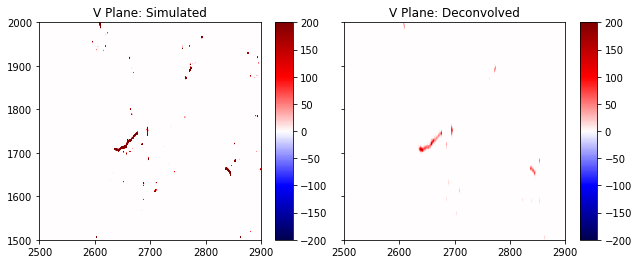

In [52]:
ch_min = idx_v0
ch_max = idx_w0

mask = np.where((abs(np.ceil(evd_sim[1]))[:-1]<ch_max) & (abs(np.ceil(evd_sim[1]))[:-1] >= ch_min), True,False)
xbins = evd_sim[1][(evd_sim[1]<ch_max) & (evd_sim[1] >= ch_min)]
ybins = evd_sim[2]

fig, axes = plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
hep.hist2dplot(H=evd_sim[0][:][mask],xbins=xbins,ybins=ybins,cmap="seismic",vmin=-2e2,vmax=2e2,ax=axes[0])
hep.hist2dplot(H=evd_dec[0][:][mask],xbins=xbins,ybins=ybins,cmap="seismic",vmin=-2e2,vmax=2e2,ax=axes[1])

axes[0].set_title("V Plane: Simulated")
axes[1].set_title("V Plane: Deconvolved")
plt.ylim(1500,2000)
plt.xlim(2500,2900)
plt.show()

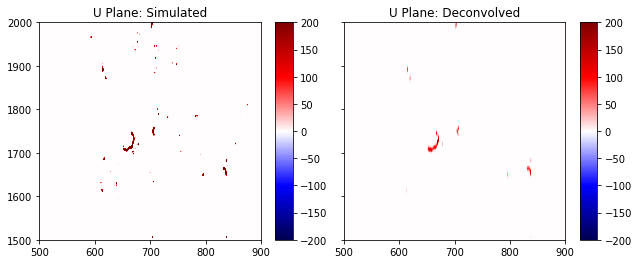

In [55]:
ch_min = 0
ch_max = idx_v0

mask = np.where((abs(np.ceil(evd_sim[1]))[:-1]<ch_max) & (abs(np.ceil(evd_sim[1]))[:-1] >= ch_min), True,False)
xbins = evd_sim[1][(evd_sim[1]<ch_max) & (evd_sim[1] >= ch_min)]
ybins = evd_sim[2]

fig, axes = plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
hep.hist2dplot(H=evd_sim[0][:][mask],xbins=xbins,ybins=ybins,cmap="seismic",vmin=-2e2,vmax=2e2,ax=axes[0])
hep.hist2dplot(H=evd_dec[0][:][mask],xbins=xbins,ybins=ybins,cmap="seismic",vmin=-2e2,vmax=2e2,ax=axes[1])

axes[0].set_title("U Plane: Simulated")
axes[1].set_title("U Plane: Deconvolved")
plt.ylim(1500,2000)
plt.xlim(500,900)
plt.show()

## Waveforms

In [85]:
evtnum = 4
# one event has 4 electrons! 2 in each tpc
sim_arr = wvfm[sim_names[evtnum]].values() 
dec_arr = wvfm[dec_names[evtnum]].values()*50 
raw_arr = wvfm[raw_names[evtnum]].values() 

nonzeroch = find_nonzero_ch(sim_arr)
u_sim_sum = np.sum(sim_arr[0:idx_v0])+ np.sum(sim_arr[idx_u1:idx_v1])  # array of sim sum of each channel
u_dec_sum = np.sum(dec_arr[0:idx_v0])+ np.sum(dec_arr[idx_u1:idx_v1])  # array of dec sum of each channel

v_sim_sum = np.sum(sim_arr[idx_v0:idx_w0])+ np.sum(sim_arr[idx_v1:idx_w1])  # array of sim sum of each channel
v_dec_sum = np.sum(dec_arr[idx_v0:idx_w0])+ np.sum(dec_arr[idx_v1:idx_w1])  # array of dec sum of each channel


print("sim sum u:", u_sim_sum)
print("dec sum u:", u_dec_sum)
print("---")
print("sim sum v", v_sim_sum)
print("dec sum v", v_dec_sum)


sim sum u: 10165621.0
dec sum u: 9259129.0
---
sim sum v 10165686.0
dec sum v 10607857.0


In [262]:
def plot_wvfms(chnum:int, range: list = [0,3400], textxcoord: float = 0.5):
    """
    Plots waveform of the specified channel number, as well as the neighborhoring two channels
    """
    fig, axes = plt.subplots(3,1,figsize=(10,10))
    for i, shift in enumerate([-1,0,1]):
        hep.histplot(wvfm[sim_names[evtnum]].values()[chnum+shift]   ,ax=axes[i], label="sim")
        hep.histplot(wvfm[raw_names[evtnum]].values()[chnum+shift]*20,ax=axes[i], label="raw [x20]")
        hep.histplot(wvfm[dec_names[evtnum]].values()[chnum+shift]*50,ax=axes[i], label="dec")
        axes[i].set_title("Channel "+str(chnum+shift))
        axes[i].set_xlim(range)
        axes[i].legend()
        sim_ch_sum = np.sum(wvfm[sim_names[evtnum]].values()[chnum+shift][range[0]:range[1]])
        dec_ch_sum = np.sum(wvfm[dec_names[evtnum]].values()[chnum+shift][range[0]:range[1]]*50)
        diff_ch = (dec_ch_sum - sim_ch_sum)/sim_ch_sum
        axes[i].annotate(f"sim integral: {sim_ch_sum:.0f}",     (textxcoord,0.8) ,xycoords='axes fraction',fontsize=12)
        axes[i].annotate(f"dec integral: {dec_ch_sum:.0f}",     (textxcoord,0.7),xycoords='axes fraction',fontsize=12)
        axes[i].annotate(f"fractional diff: {diff_ch*100:.1f}%",(textxcoord,0.6),xycoords='axes fraction',fontsize=12)
    plt.show()

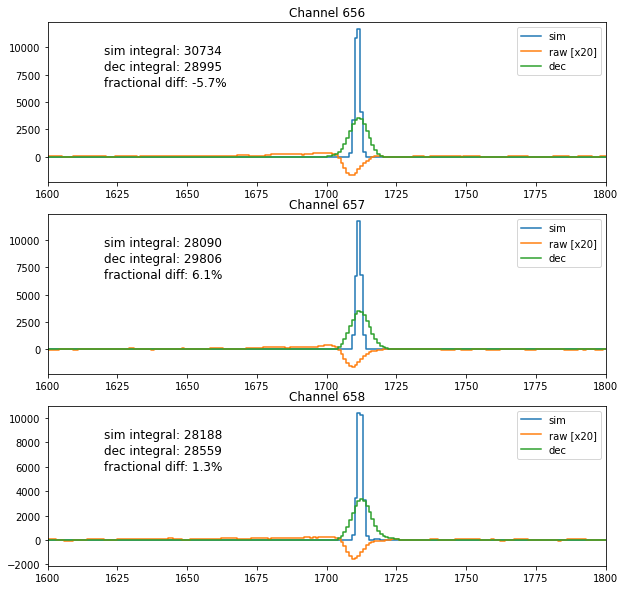

In [153]:
plot_wvfms(nonzeroch[10],
           range=[1600,1800],
           textxcoord=0.1)

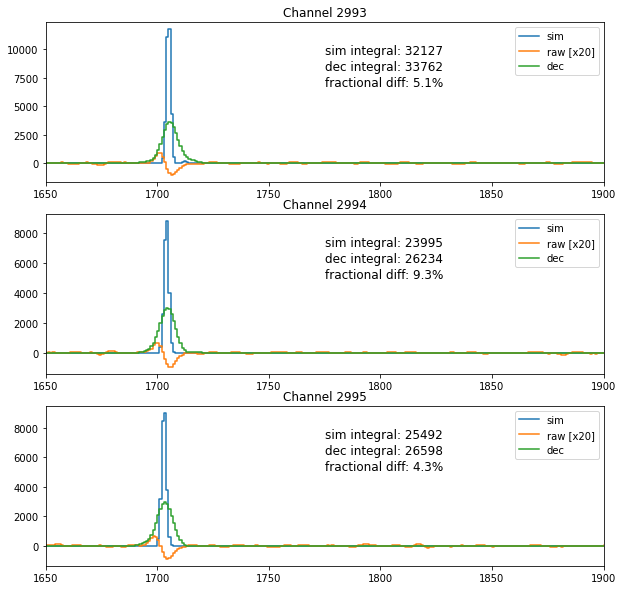

In [149]:
plot_wvfms(nonzeroch[225],
           range=[1650,1900],
           textxcoord=0.5)

In [ ]:

# fig, axes = plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
# u_out = axes[0].hist2d(np.sum(u_sim,axis=1),np.sum(u_dec,axis=1),bins=[np.linspace(0,20,21),np.linspace(0,5e4,100)],
#                norm=mpl.colors.LogNorm()
#                )
# v_out = axes[1].hist2d(np.sum(v_sim,axis=1),np.sum(v_dec,axis=1),bins=[np.linspace(0,20,21),np.linspace(0,5e4,100)],
#                norm=mpl.colors.LogNorm()
#                )

# axes[0].plot([0,1e10],[0,1e10],color="red",linestyle="--")
# axes[1].plot([0,1e10],[0,1e10],color="red",linestyle="--")

# axes[0].set_title("U Plane")
# axes[1].set_title("V Plane")
# axes[0].set_xlabel("Simulated Sum   (Channel)")
# axes[1].set_xlabel("Simulated Sum   (Channel)")
# axes[0].set_ylabel("Deconvolved Sum (Channel)")
# plt.show()

### comparing U and V

channel-by-channel
- for a given sim deposit on a channel, what is the corresponding decon charge? 

In [517]:
for evtnum in range(10):
    # one event has 4 electrons! 2 in each tpc
    sim_arr = wvfm[sim_names[evtnum]].values() 
    dec_arr = wvfm[dec_names[evtnum]].values()*50 
    # raw_arr = wvfm[raw_names[evtnum]].values() 

    u_ch = np.concatenate([np.arange(0,idx_v0),np.arange(idx_u1,idx_v1)])
    u_sim = np.concatenate([sim_arr[0:idx_v0],sim_arr[idx_u1:idx_v1]])
    u_dec = np.concatenate([dec_arr[0:idx_v0],dec_arr[idx_u1:idx_v1]])

    v_ch = np.concatenate([np.arange(idx_v0,idx_w0),np.arange(idx_v1,idx_w1)])
    v_sim = np.concatenate([sim_arr[idx_v0:idx_w0],sim_arr[idx_v1:idx_w1]])
    v_dec = np.concatenate([dec_arr[idx_v0:idx_w0],dec_arr[idx_v1:idx_w1]])

    w_ch = np.concatenate([np.arange(idx_w0,idx_u1),np.arange(idx_w1,11265)])
    w_sim = np.concatenate([sim_arr[idx_w0:idx_u1],sim_arr[idx_w1:]])
    w_dec = np.concatenate([dec_arr[idx_w0:idx_u1],dec_arr[idx_w1:]])

    v_ndec = len(np.where(pass_decon(v_dec)==True)[0])
    u_ndec = len(np.where(pass_decon(u_dec)==True)[0]) 
    w_ndec = len(np.where(pass_decon(w_dec)==True)[0])

    v_nsim = len(np.where(pass_sim(v_sim)==True)[0])
    u_nsim = len(np.where(pass_sim(u_sim)==True)[0])
    w_nsim = len(np.where(pass_sim(w_sim)==True)[0])

    noise_ch = np.where(( pass_decon(dec_arr)) & (~pass_sim(sim_arr)))[0]
    fail_ch  = np.where((~pass_decon(dec_arr)) & ( pass_sim(sim_arr)))[0]

    u_nnoise = len(np.where(((noise_ch < idx_v0) & (noise_ch > 0)) | ((noise_ch > idx_u1) & (noise_ch < idx_v1)))[0])
    v_nnoise = len(np.where(((noise_ch < idx_w0) & (noise_ch > idx_v0)) | ((noise_ch > idx_v1) & (noise_ch < idx_w1)))[0])
    w_nnoise = len(np.where(((noise_ch < idx_u1) & (noise_ch > idx_w0)) | (noise_ch > idx_w1))[0])

    u_nfail = len(np.where(((fail_ch < idx_v0) & (fail_ch > 0)) | ((fail_ch > idx_u1) & (fail_ch < idx_v1)))[0])
    v_nfail = len(np.where(((fail_ch < idx_w0) & (fail_ch > idx_v0)) | ((fail_ch > idx_v1) & (fail_ch < idx_w1)))[0])
    w_nfail = len(np.where(((fail_ch < idx_u1) & (fail_ch > idx_w0)) | (fail_ch > idx_w1))[0])

    # purity: number of decon channels that aren't a "ghost" hit, where a decon channel is included in the count if its charge integral is > 500
    print("purity of u decon: ", (1-u_nnoise/u_ndec)*100)
    print("purity of v decon: ", (1-v_nnoise/v_ndec)*100)
    print("purity of w decon: ", (1-w_nnoise/w_ndec)*100)

    # efficiency: percent of sim channels (above threshold) that have any deconvolved charge
    print("efficiency of u decon: ", (1-u_nfail/u_nsim)*100)
    print("efficiency of v decon: ", (1-v_nfail/v_nsim)*100)
    print("efficiency of w decon: ", (1-w_nfail/w_nsim)*100)

purity of u decon:  98.88888888888889
purity of v decon:  89.49044585987261
purity of w decon:  99.73890339425587
efficiency of u decon:  86.40776699029126
efficiency of v decon:  89.77635782747603
efficiency of w decon:  92.04819277108433
purity of u decon:  98.88059701492537
purity of v decon:  83.17757009345794
purity of w decon:  100.0
efficiency of u decon:  92.98245614035088
efficiency of v decon:  91.28205128205128
efficiency of w decon:  93.00518134715026
purity of u decon:  100.0
purity of v decon:  87.34693877551021
purity of w decon:  100.0
efficiency of u decon:  88.33922261484099
efficiency of v decon:  85.2589641434263
efficiency of w decon:  92.50585480093677
purity of u decon:  99.48186528497409
purity of v decon:  89.0625
purity of w decon:  100.0
efficiency of u decon:  88.88888888888889
efficiency of v decon:  92.3076923076923
efficiency of w decon:  94.82288828337875
purity of u decon:  99.56331877729258
purity of v decon:  86.56126482213439
purity of w decon:  100.

In [534]:
np.shape(u_sim)

(3968, 3400)